In [12]:
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.evaluation import evaluate
from utilsforecast.losses import mase
from datasetsforecast.hierarchical import HierarchicalData

# 1. Load the benchmark dataset
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismSmall')

# FIX: S_df must have unique_id as a column, not an index
S_df = S_df.reset_index(names="unique_id")

# Force all timestamps to the start of the quarter to match StatsForecast output
Y_df['ds'] = pd.to_datetime(Y_df['ds']).dt.to_period('Q').dt.to_timestamp()

# Ensure unique_id is a standard string object to match tags
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

# Split into training and testing
test_size = 8
test_df = Y_df.groupby('unique_id').tail(test_size)
train_df = Y_df.drop(test_df.index)

# 2. Generate Base Forecasts
sf = StatsForecast(
    models=[AutoETS(season_length=4)],
    freq='QS',
    n_jobs=1 
)
y_hat = sf.forecast(df=train_df, h=test_size)

# 3. Apply Reconciliation
reconcilers = [
    BottomUp(),
    MinTrace(method='wls_struct')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
y_rec = hrec.reconcile(Y_hat_df=y_hat, S_df=S_df, tags=tags)

# Step 4: Evaluation
# Define MASE with a seasonality of 4 for quarterly tourism data
quarterly_mase = partial(mase, seasonality=4)

# Merge predictions with test actuals
full_df = y_rec.merge(test_df, on=['unique_id', 'ds'])
    
# Pass the partial function to evaluate
perf = evaluate(
    df=full_df, 
    metrics=[quarterly_mase], 
    tags=tags, 
    train_df=train_df
)

# Summary Visualization

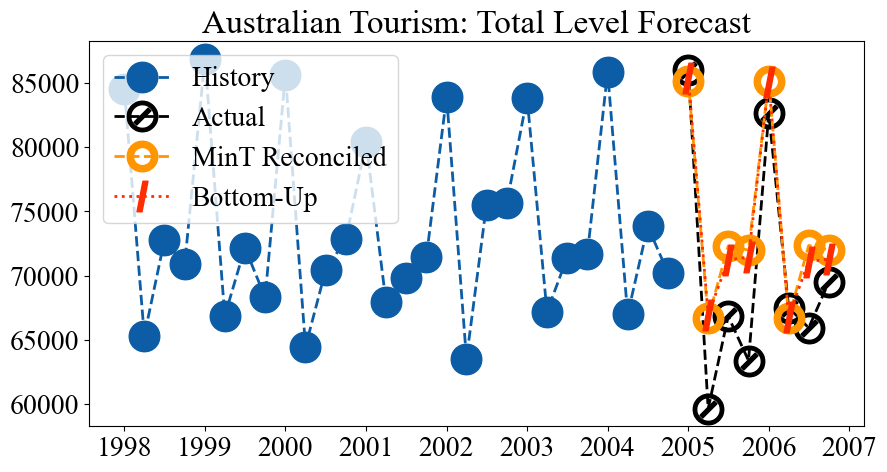

In [11]:
# The dataset uses 'total' for the national aggregate
uid = 'total'
method = 'AutoETS/MinTrace_method-wls_struct'

# Filter data for the top-level node
hist = train_df[train_df['unique_id'] == uid]
actuals = test_df[test_df['unique_id'] == uid]
preds = y_rec[y_rec['unique_id'] == uid]

plt.figure(figsize=(10, 5))
plt.plot(hist['ds'], hist['y'], label='History')
plt.plot(actuals['ds'], actuals['y'], label='Actual', color='black', lw=2)
plt.plot(preds['ds'], preds[method], label='MinT Reconciled', linestyle='--')
plt.plot(preds['ds'], preds['AutoETS/BottomUp'], label='Bottom-Up', linestyle=':')
plt.title(f'Australian Tourism: {uid.capitalize()} Level Forecast')
plt.legend()
plt.show()